## Extracting Leaf Traits from 3D data

### Last edited: M. Jenkins
### 04.13.18

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
import skimage
from skimage import io
from skimage.util import invert
from skimage.transform import rescale
from skimage.morphology import remove_small_objects, skeletonize_3d, medial_axis
from skimage.measure import marching_cubes_lewiner, mesh_surface_area
from scipy.ndimage.morphology import distance_transform_edt
from scipy.ndimage.filters import maximum_filter, median_filter, minimum_filter, percentile_filter

In [2]:
# Define filters for clipping off artefactual protrusions
def dbl_pct_filt(arr):
    out = percentile_filter(
        percentile_filter(
            arr, 
            size=30, 
            percentile=10),
        size=30,percentile=90)
    return(out)
def min_max_filt(arr):
    out = minimum_filter(
        maximum_filter(arr,1),
        1)
    return out

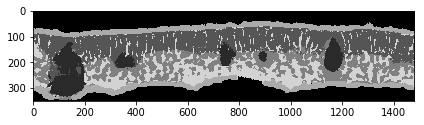

In [3]:
# Import full stack prediction from ML algorithm
# filepath = '../../../ML_microCT/results/'
filepath = '../results/'
results_folder = 'test3_10'
img = io.imread(filepath+results_folder+'/post_processed_fullstack.tif')
io.imshow(img[0,:,:])
io.show()

In [4]:
# define pixel values
epidermis = 170
spongy = 128
palisade = 85
ias = 212
bg = 0
vein = 42

In [5]:
# Define 3D array of distances from lowest value img.shape[1] to highest values
a = range(0,img.shape[1])
b = np.tile(a,(img.shape[2],img.shape[0],1))
b = np.moveaxis(b,[0,1,2],[2,0,1])

# Define 3D array of distances from lower value of img.shape[1] to median value
rangeA = range(0,img.shape[1]/2)
tileA = np.tile(rangeA,(img.shape[2],img.shape[0],1))
tileA = np.moveaxis(tileA,[0,1,2],[2,0,1])

# Define 3D array of distances from upper value of image.shape[1] to median value
rangeB = range(img.shape[1]/2,img.shape[1])
tileB = np.tile(rangeB,(img.shape[2],img.shape[0],1))
tileB = np.moveaxis(tileB,[0,1,2],[2,0,1])
tileB = np.flip(tileB,1)

/Users/mattjenkins1/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


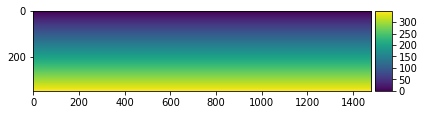

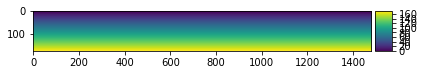

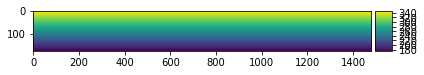

In [6]:
%matplotlib inline
io.imshow(b[0,:,:])
io.show()
io.imshow(tileA[0,:,:])
io.show()
io.imshow(tileB[0,:,:])
io.show()

In [7]:
hold = img.shape[1]/2
img2 = np.array(img, copy=True)
imgconc1 = np.array(img[:,0:hold,:], copy = True) 
imgconc2 = np.array(img[:,hold:img.shape[1],:], copy = True)

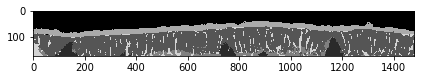

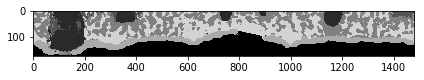

In [8]:
%matplotlib inline
io.imshow(imgconc1[0,:,:])
io.show()
io.imshow(imgconc2[0,:,:])
io.show()

In [9]:
# Determine the upper edge of the palisade mesophyll
c = (imgconc1==palisade)
d = (tileA*c)
p_low_in = np.argmin(d, axis=1)
        
# Determine the upper edge of ias
c = (imgconc1==ias)
d = (tileA*c)
ias_low_in = np.argmin(d, axis=1)   

# Determine the inner edge of the upper epidermis
c = (imgconc1==epidermis)
d = (tileA*c)
e_low_in = np.argmax(d, axis=1)

e_low_in = np.maximum(e_low_in, p_low_in) # Checks if mesophyll cells are below lower epidermis
                                 # Changes mesophyll pixel to epidermal class
e_low_in = np.maximum(e_low_in, ias_low_in) # Similar to above, but with ias

epi_low_in = np.zeros(img.shape)
for z in range(0,epi_low_in.shape[0]):
    for x in range(0,epi_low_in.shape[2]):
        epi_low_in[z,e_low_in[z,x],x] = 1

# Determine the lower edge of the spongy mesophyll
c = (imgconc2==spongy)
d = (tileA*c)
m_up_in = np.argmax(d, axis=1)
# Determins the lower edge of vein
c = (imgconc2==vein)
d = (tileA*c)
v_up_in = np.argmax(d,axis=1)
# Determine the lower edge of ias
c = (imgconc2==ias)
d = (tileA*c)
ias_up_in = np.argmax(d, axis=1)        

#Determine the inner edge of the lower epidermis
c = (imgconc2==epidermis)
d = (tileB*c)
e_up_in = np.argmax(d, axis=1)

e_up_in = np.maximum(e_up_in, m_up_in) # Checks if mesophyll cells are below lower epidermis
                                 # Changes lowest mesophyll pixel to epidermal class
e_up_in = np.maximum(e_up_in, ias_up_in) # Similar to above, but with ias
e_up_in = np.maximum(e_up_in, v_up_in)
epi_up_in = np.zeros(img.shape)
hold = img.shape[1]/2
for z in range(0,epi_up_in.shape[0]):
    for x in range(0,epi_up_in.shape[2]):
        epi_up_in[z,e_up_in[z,x]+hold,x] = 1
#add lower and upper halves
epi_inner_trace = np.add(epi_low_in,epi_up_in)

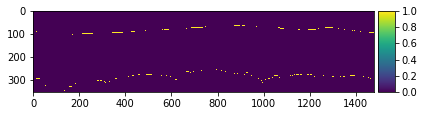

In [10]:
%matplotlib inline
# io.imshow(epi_low_in[0,:,:])
# io.show()
# io.imshow(epi_up_in[0,:,:])
# io.show()
io.imshow(epi_inner_trace[0,:,:])
io.show()

In [11]:
# Determine the lower edge of the spongy mesophyll
c = (img==spongy)
d = (b*c)
m_low = np.argmax(d, axis=1)
        
# Determine the lower edge of the vascular bundle
c = (img==vein)
d = (b*c)
v_low = np.argmax(d, axis=1)

# Determine the lower edge of the epidermis
c = (img==epidermis)
d = (b*c)
e_low = np.argmax(d, axis=1)
e_low = np.maximum(e_low, m_low) # Changes lowest mesophyll pixel to epidermal class
e_low = np.maximum(e_low, v_low) # Changes lowest vein pixel to epidermal class
epi_low = np.zeros(img.shape)
for z in range(0,epi_low.shape[0]):
    for x in range(0,epi_low.shape[2]):
        epi_low[z,e_low[z,x],x] = 1

# Determine the upper edge of epidermis
b2 = np.flip(b,1)
d = (b2*c)
e_up = np.argmax(d, axis=1)
epi_up = np.zeros(img.shape)
for z in range(0,epi_up.shape[0]):
    for x in range(0,epi_up.shape[2]):
        epi_up[z,e_up[z,x],x] = 1

# Combine the lower and upper outer edge of epidermis into a single numpy array
epi_both = epi_up + epi_low

In [12]:
# Combine inner and outer edges of epidermis into single array
epidermis_in_out = np.add(epi_inner_trace,epi_both)

/Users/mattjenkins1/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


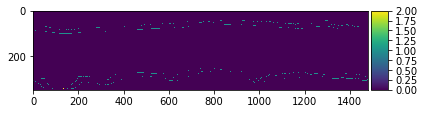

In [13]:
%matplotlib inline
io.imshow(epidermis_in_out[0,:,:])
io.show()
# io.imshow(epidermis_in_out[0,:,:])
# io.show()

In [14]:
list_thing = []
for z in range(0,epi_inner_trace.shape[0]):
    for y in range(0,epi_inner_trace.shape[2]):
        for x in range(0,epi_inner_trace.shape[1]):
            if epi_inner_trace[z,x,y] == 1:
                list_thing.append(x)

distance_list = []
i = 0
while i < len(list_thing)-2:
    hold = list_thing[i+1]-list_thing[i]
    distance_list.append(hold)
    i = i + 2
distance = np.mean(distance_list)
print('Mean mesophyll thickness: '+str(distance)+' pixels')

Mean mesophyll thickness: 194.344241006 pixels


In [15]:
# convert from pixels to uM, scan was taken at 10x mag so 0.636uM/px
print('True mean mesophyll thickness: '+str(distance*0.636)+' microMeters')

True mean mesophyll thickness: 123.60293728 microMeters


In [16]:
# set up array for each pixel class, to calculate SA
vein_trace = (img==vein)
spongy_trace = (img==spongy)
palisade_trace = (img==palisade)

# Generate a binary stack with the pixels inside the epidermis set equal to 1
epi_in = np.zeros(img.shape, dtype=np.uint16)
for y in range(0,epi_in.shape[2]):
    for z in range(0,epi_in.shape[0]):
        epi_in[z,e_up[z,y]:e_low[z,y],y] = 1
epi_in_trace = (epi_in==1)

# %matplotlib inline
# io.imshow(vein_trace[10,:,:])
# io.show()
# io.imshow(vein_trace[:,180,:])
# io.show()
# io.imshow(spongy_trace[10,:,:])
# io.show()
# io.imshow(palisade_trace[10,:,:])
# io.show()
# io.imshow(epi_in_trace[10,:,:])
# io.show()

In [17]:
vein_vert_faces = marching_cubes_lewiner(vein_trace)
vein_SA = mesh_surface_area(vein_vert_faces[0],vein_vert_faces[1])
print('Vein SA: '+str(vein_SA*0.404496)+' microMeters**2')

spongy_vert_faces = marching_cubes_lewiner(spongy_trace)
spongy_SA = mesh_surface_area(spongy_vert_faces[0],spongy_vert_faces[1])
print('Spongy SA: '+str(spongy_SA*0.404496)+' microMeters**2')

palisade_vert_faces = marching_cubes_lewiner(palisade_trace)
palisade_SA = mesh_surface_area(palisade_vert_faces[0],palisade_vert_faces[1])
print('Palisade SA: '+str(palisade_SA*0.404496)+' microMeters**2')

# IAS surface area is not an accurate representation of mesophyll surface area because it counts epidermal surfaces
ias_trace = (img==ias)
ias_vert_faces = marching_cubes_lewiner(ias_trace)
ias_SA = mesh_surface_area(ias_vert_faces[0],ias_vert_faces[1])
print('therefore total ias SA: '+str(ias_SA*0.404496)+' microMeters**2')

print('Projected abaxial epidermis SA: '+str(img.shape[0]*img.shape[2]*0.404496)+' microMeters**2')

# Caluculating Sm value requires an accurate representation of mesophyll surface area
# print('therefore Sm: '+str(float(ias_SA)/(img.shape[0]*img.shape[2])))

Vein SA: 721407.138426 microMeters**2
Spongy SA: 5351912.46374 microMeters**2
Palisade SA: 4708747.6439 microMeters**2
therefore total ias SA: 5553303.33672 microMeters**2
Projected abaxial epidermis SA: 299327.04 microMeters**2


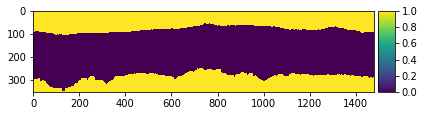

In [18]:
# Generate a binary stack with the pixels inside the inner epidermis trace set equal to 1
epi_inner_up = np.zeros(imgconc1.shape, dtype=np.uint16)
for y in range(0,epi_inner_up.shape[2]):
    for z in range(0,epi_inner_up.shape[0]):
        epi_inner_up[z,:e_up_in[z,y],y] = 1

epi_inner_down = np.zeros(imgconc2.shape, dtype=np.uint16)
for y in range(0,epi_inner_down.shape[2]):
    for z in range(0,epi_inner_down.shape[0]):
        epi_inner_down[z,:e_low_in[z,y],y] = 1
epi_inner_down = (epi_inner_down==0)*1

#add lower and upper halves
epi_inner_fill = np.concatenate((epi_inner_down,epi_inner_up), axis = 1)
epi_inner_fill_invert = (epi_inner_fill==0)*1

io.imshow(epi_inner_fill_invert[10,:,:])
io.show()

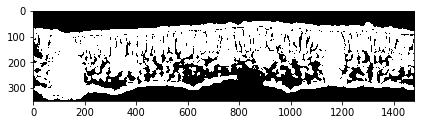

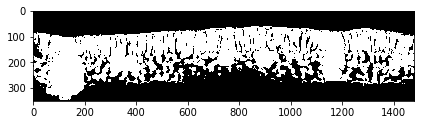

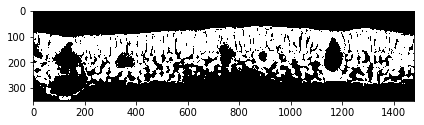

In [20]:
ias_trace = (img==ias)
ias_trace_invert = invert(ias_trace)
epi_in_trace_invert = invert(epi_in_trace)
# Set all pixels that lie outside epidermal boundaries as False
img2 = np.array(ias_trace_invert, copy=True)
img2[(img2==1)*(epi_in_trace_invert==1)] = 0
io.imshow(img2[0,:,:])
io.show()

# Set all pixels that lie outside inner epidermal boundaries as False
img3 = np.array(ias_trace_invert, copy=True)
img3[(img3==1)*(epi_inner_fill_invert==1)] = 0
io.imshow(img3[0,:,:])
io.show()

# Copy img3 then set all vein pixels as False
img4 = np.array(img3, copy=True)
img4[(img4==1)*(vein_trace==1)] = 0
io.imshow(img4[0,:,:])
io.show()

# First image below shows all gas exchange surfaces
# Second image shows ONLY all mesophyll gas exchange surfaces exposed to IAS
# Third image shows only all mesophyll pixels, for calculating mesophyll volume

In [21]:
totalmeso_vert_faces = marching_cubes_lewiner(img3)
totalmeso_SA = mesh_surface_area(totalmeso_vert_faces[0],totalmeso_vert_faces[1])
true_totalmeso_SA = totalmeso_SA * 0.404496
print('Total Mesophyll surface area exposed to IAS: '+str(true_totalmeso_SA)+' microMeters**2')
# Caluculating Sm value requires an accurate representation of mesophyll surface area
print('therefore Sm: '+str(float(totalmeso_SA)/(img3.shape[0]*img3.shape[2])))
print('Sm is mesophyll surface area per projected leaf surface area')

Total Mesophyll surface area exposed to IAS: 6366258.18403 microMeters**2
therefore Sm: 21.2685702703
Sm is mesophyll surface area per projected leaf surface area


In [22]:
# simple method for mesophyll volume, too slow ...but
# still faster than other methods which require making an .stl mesh first
meso_volume = 0
for z in range(0,img4.shape[0]):
    for y in range(0,img4.shape[2]):
        for x in range(0,img4.shape[1]):
            if img4[z,x,y] == 1:
                meso_volume = meso_volume + 1
true_meso_volume = meso_volume * 0.257259456
print('total mesophyll volume = '+str(true_meso_volume)+' microMeters**3')

total mesophyll volume = 22799719.1047 microMeters**3


In [23]:
# Mesophyll surface area exposed to IAS over mesophyll volume
print('therefore mesophyll surface area per mesophyll volume = '+str(float(true_totalmeso_SA/true_meso_volume))+' micrometers**-1')

therefore mesophyll surface area per mesophyll volume = 0.279225290224 micrometers**-1


In [24]:
# method for getting volume of ias
ias_volume = 0
for z in range(0,img4.shape[0]):
    for y in range(0,img4.shape[2]):
        for x in range(0,img4.shape[1]):
            if ias_trace[z,x,y] == 1:
                ias_volume = ias_volume + 1
true_ias_volume = ias_volume * 0.257259456
print('θ IAS = '+str(true_ias_volume/true_meso_volume)+' microMeters**3')
print('θ IAS is mesophyll porosity, calculated as the IAS volume as a fraction of the total mesophyll volume')

θ IAS = 1.0 microMeters**3
θ IAS is mesophyll porosity, calculated as the IAS volume as a fraction of the total mesophyll volume


In [ ]:
# figure out some way to calculate vein position, tried skeletonize to get line at central axis
# clearly, did not work
# need some other method, or preprocess (smooth a lot) vein_trace before passing to skeletonize_3d?

# skeleton_vein_trace = skeletonize_3d(vein_trace)
# io.imshow(vein_trace[:,185,:])
# io.show()

# skeleton_vein_trace = medial_axis(vein_trace)
# io.imshow(skeleton_vein_trace[:,195,:])
# io.show()

vein_trace_smooth = np.apply_along_axis(dbl_pct_filt, 0, arr = vein_trace)
io.imshow(vein_trace_smooth[:,185,:])
io.show()

data = np.array(vein_trace_smooth[:,185,:], copy = True)
skel, distance = medial_axis(data, return_distance=True)
vein_medial_axis = distance * skel
io.imshow(vein_medial_axis)
io.show()

In [ ]:
palisade_trace_minmax = np.apply_along_axis(min_max_filt, 2, arr = palisade_trace)

In [ ]:
# io.imshow(palisade_trace_minmax[16,0:150,700:800])
# io.show()
# io.imshow(palisade_trace[16,0:150,700:800])
# io.show()

In [ ]:
img2 = np.array(img, copy=True)
palisade_rmv_parts = np.array(palisade_trace, copy=True)
for i in range(0,palisade_rmv_parts.shape[0]):
    palisade_rmv_parts[i,:,:] = remove_small_objects(palisade_trace[i,:,:], min_size=16, connectivity=10)

# Write an array of just the removed particles
palisade_parts = palisade_trace ^ palisade_rmv_parts

# Replace the small connected epidermal particles (< 800 px^2) with BG value
img2[palisade_parts==1] = bg

In [ ]:
# io.imshow(palisade_parts[65,:,:])
# io.show()
# io.imshow(img2[65,0:150,700:800])
# io.show()
# io.imshow(img[65,0:150,700:800])
# io.show()